![alt text](../img/header.jpg)

# Groundwater Transport

In [2]:
import os
import sys
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.8 |Anaconda custom (x86_64)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
python executable: /Users/mnfienen/anaconda3/bin/python
numpy version: 1.13.1
matplotlib version: 2.2.2
flopy version: 3.2.13


In [9]:
def get_model(workspace, model_name='mymodel'):
    nlay, nrow, ncol = 40, 12, 30
    nper = 1
    perlen = [400]
    nstp = [400]
    tsmult = [1.]
    steady = [True]
    delr = 3.0
    delc = 3.0
    top = 0.
    delz = 0.05
    botm =  np.arange(-delz, -nlay*delz - delz, -delz)
    strt = 0.
    hnoflo = 1e30
    hdry = -1e30
    hk = 0.0125 / delz
    laytyp = 0
    diffc = 0.
    alphal = 0.6
    alphath = 0.03
    alphatv = 0.006
    porosity = 0.25
    #ss = 0.
    #sy = 0.1

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-4, 1e-3, 0.97

    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    name = model_name

    # build MODFLOW 6 files
    ws = workspace
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6beta',
                                 exe_name=os.path.abspath('../bin/macos/mf6beta'),
                                 sim_ws=ws)
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname,
                            model_nam_file='{}.nam'.format(gwfname))

    # create iterative model solution and register the gwf model with it
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='CG',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname))
    sim.register_ims_package(imsgwf, [gwf.name])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=np.int),
                                  filename='{}.dis'.format(gwfname))

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=strt,
                                filename='{}.ic'.format(gwfname))

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_flows=False,
                                  save_specific_discharge=True,
                                  icelltype=laytyp,
                                  k=hk,
                                  k33=hk)

    # chd files
    chdlist = []
    j = ncol - 1
    for k in range(nlay):
        for i in range(nrow):
            chdlist.append([(k, i, j), 0.])
    chd = flopy.mf6.ModflowGwfchd(gwf,
                                  stress_period_data=chdlist,
                                  save_flows=False,
                                  pname='CHD-1')

    # wel files
    wellist = []
    j = 0
    qwell = 0.1 * delz * delc * porosity
    for k in range(nlay):
        for i in range(nrow):
            wellist.append([(k, i, j), qwell, 0.])
    wellist.append([(0, 0, 7), 1.e-6, 2.5e6])  # source well

    wel = flopy.mf6.ModflowGwfwel(gwf,
                                  print_input=True,
                                  print_flows=True,
                                  stress_period_data=wellist,
                                  save_flows=False,
                                  auxiliary='CONCENTRATION',
                                  pname='WEL-1')

    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # create gwt model
    gwtname = 'gwt_' + name
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwtname))
    sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=1,
                                  filename='{}.dis'.format(gwtname))

    # initial conditions
    strt = np.zeros((nlay, nrow, ncol))
    strt[0, 0, 0] = 0.
    ic = flopy.mf6.ModflowGwtic(gwt, strt=strt,
                                filename='{}.ic'.format(gwtname))

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='TVD',
                                  filename='{}.adv'.format(gwtname))

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=None, diffc=diffc,
                                  alh=alphal, alv=alphal,
                                  ath1=alphath, ath2=alphatv,
                                  filename='{}.dsp'.format(gwtname))

    # storage
    sto = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity,
                                filename='{}.sto'.format(gwtname))

    # sources
    sourcerecarray = [('WEL-1', 'aux', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                filename='{}.ssm'.format(gwtname))

    # output control
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('CONCENTRATION', 'ALL')],
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [10]:
workspace = 'ex0x-completed-transport'
sim = get_model(workspace)

In [11]:
# write the input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package mymodel.gwfgwt...
  writing model gwf_mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 480 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 481 based on size of stress_period_data
    writing package oc...
  writing model gwt_mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...


In [12]:
# run the simulation
sim.run_simulation()

FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/mf6flopy2019_Neuchatel/notebooks/bin/macos/mf6beta
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.5 03/31/2019
                               ***DEVELOP MODE***

  MODFLOW 6 compiled Nov 13 2019 13:50:43 with GFORTRAN compiler (ver. 9.2.0)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the

 Solving:  Stress period:     1    Time step:   139
 Solving:  Stress period:     1    Time step:   140
 Solving:  Stress period:     1    Time step:   141
 Solving:  Stress period:     1    Time step:   142
 Solving:  Stress period:     1    Time step:   143
 Solving:  Stress period:     1    Time step:   144
 Solving:  Stress period:     1    Time step:   145
 Solving:  Stress period:     1    Time step:   146
 Solving:  Stress period:     1    Time step:   147
 Solving:  Stress period:     1    Time step:   148
 Solving:  Stress period:     1    Time step:   149
 Solving:  Stress period:     1    Time step:   150
 Solving:  Stress period:     1    Time step:   151
 Solving:  Stress period:     1    Time step:   152
 Solving:  Stress period:     1    Time step:   153
 Solving:  Stress period:     1    Time step:   154
 Solving:  Stress period:     1    Time step:   155
 Solving:  Stress period:     1    Time step:   156
 Solving:  Stress period:     1    Time step:   157
 Solving:  S

 Solving:  Stress period:     1    Time step:   297
 Solving:  Stress period:     1    Time step:   298
 Solving:  Stress period:     1    Time step:   299
 Solving:  Stress period:     1    Time step:   300
 Solving:  Stress period:     1    Time step:   301
 Solving:  Stress period:     1    Time step:   302
 Solving:  Stress period:     1    Time step:   303
 Solving:  Stress period:     1    Time step:   304
 Solving:  Stress period:     1    Time step:   305
 Solving:  Stress period:     1    Time step:   306
 Solving:  Stress period:     1    Time step:   307
 Solving:  Stress period:     1    Time step:   308
 Solving:  Stress period:     1    Time step:   309
 Solving:  Stress period:     1    Time step:   310
 Solving:  Stress period:     1    Time step:   311
 Solving:  Stress period:     1    Time step:   312
 Solving:  Stress period:     1    Time step:   313
 Solving:  Stress period:     1    Time step:   314
 Solving:  Stress period:     1    Time step:   315
 Solving:  S

(True, [])

In [13]:
list(sim.model_names)[0]

'gwf_mymodel'

In [14]:
print(sim.model_names)
gwfname = list(sim.model_names)[0]
gwtname = list(sim.model_names)[1]
gwf = sim.get_model(gwfname)
gwt = sim.get_model(gwtname)

odict_keys(['gwf_mymodel', 'gwt_mymodel'])


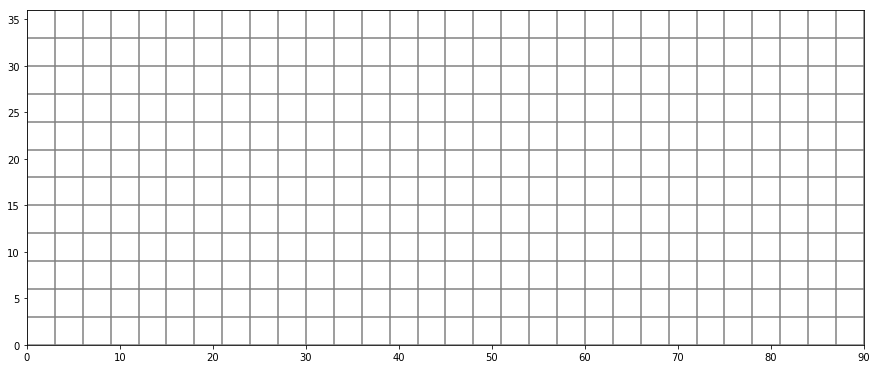

In [15]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf)
pmv.plot_grid()

In [16]:
fname = os.path.join(workspace, gwtname + '.ucn')
concobj = flopy.utils.HeadFile(fname, text='CONCENTRATION')
conc = concobj.get_data()
time_series = concobj.get_ts([(0, 0, 10), (20, 0, 10)])

In [17]:
conctimes = concobj.get_times()
conctimes

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

In [18]:
# make a movie!
if not os.path.exists('tmpimages'):
    os.mkdir('tmpimages')
i=0
for ct in concobj.get_times():
    i+=1
    conc = concobj.get_data(totim=ct)
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 1, 1, aspect='equal')
    pmv = flopy.plot.PlotMapView(model=gwf, layer=3)
    pmv.plot_grid(color='.5')
    conc2plot = np.ma.masked_less_equal(conc, 1)
    pa = pmv.plot_array(conc2plot, alpha=0.5, cmap='jet')
    pmv.contour_array(conc, levels=[.1, 1, 10, 100, 1000])
    plt.colorbar(pa, shrink=0.345691)
    plt.title('time={0}'.format(ct))
    plt.savefig('tmpimages/outfig{0}.png'.format(i))
    plt.close('all')

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


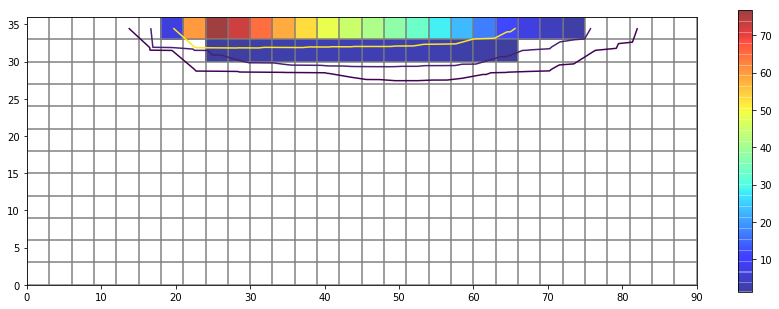

In [19]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, layer=3)
pmv.plot_grid(color='.5')
conc2plot = np.ma.masked_less_equal(conc, 1)
pa = pmv.plot_array(conc2plot, alpha=0.5, cmap='jet')
pmv.contour_array(conc, levels=[.1, 1, 10, 100, 1000])
plt.colorbar(pa, shrink=0.345691)

In [20]:
# Use ffmpeg to make an animation
if True:
    figdir = 'tmpimages/'
    from subprocess import check_output
    figfile = os.path.join(figdir, 'outfig%d.png')
    anmfile = 'movie.mp4'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vcodec', 'libx264',
                           '-pix_fmt', 'yuv420p',
                           anmfile])

Text(0,0.5,'CONCENTRATION')

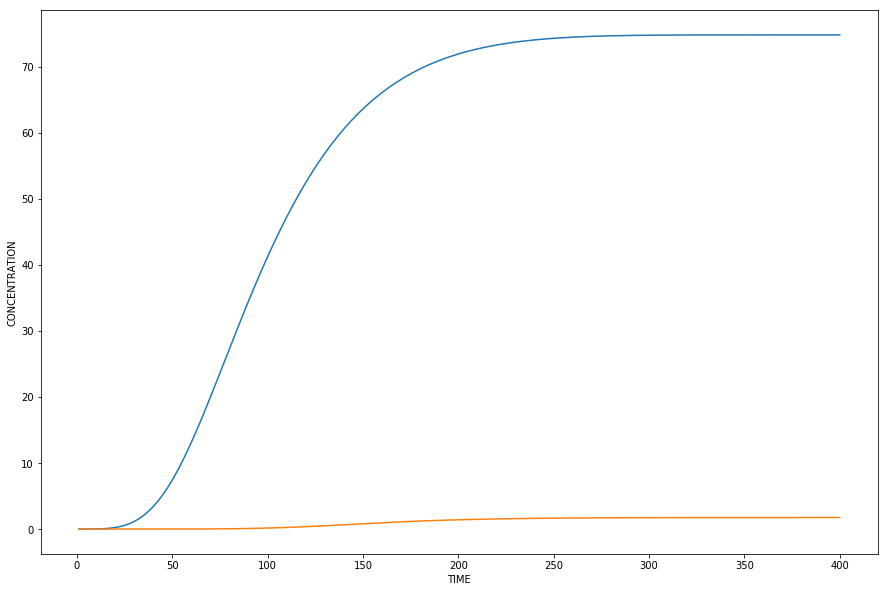

In [21]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
ax.plot(time_series[:, 0], time_series[:, 1:])
ax.set_xlabel('TIME')
ax.set_ylabel('CONCENTRATION')